In [36]:
import matplotlib.pyplot as plt
from itertools import chain
import sklearn
import nltk
import scipy.sparse
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
nltk.download('conll2002')
import sklearn_crfsuite
from sklearn_crfsuite import scorers, metrics


[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\rsury\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [37]:
nltk.corpus.conll2002.fileids()


['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [38]:
# %%time
train_sents = list(nltk.corpus.conll2002.iob_sents("esp.train"))
test_sents = list(nltk.corpus.conll2002.iob_sents("esp.testb"))


In [39]:
test_sents

[[('La', 'DA', 'B-LOC'),
  ('Coruña', 'NC', 'I-LOC'),
  (',', 'Fc', 'O'),
  ('23', 'Z', 'O'),
  ('may', 'NC', 'O'),
  ('(', 'Fpa', 'O'),
  ('EFECOM', 'NP', 'B-ORG'),
  (')', 'Fpt', 'O'),
  ('.', 'Fp', 'O')],
 [('-', 'Fg', 'O')],
 [('Las', 'DA', 'O'),
  ('reservas', 'NC', 'O'),
  ('"', 'Fe', 'O'),
  ('on', 'NC', 'O'),
  ('line', 'AQ', 'O'),
  ('"', 'Fe', 'O'),
  ('de', 'SP', 'O'),
  ('billetes', 'NC', 'O'),
  ('aéreos', 'AQ', 'O'),
  ('a', 'SP', 'O'),
  ('través', 'NC', 'O'),
  ('de', 'SP', 'O'),
  ('Internet', 'NC', 'B-MISC'),
  ('aumentaron', 'VMI', 'O'),
  ('en', 'SP', 'O'),
  ('España', 'VMN', 'B-LOC'),
  ('un', 'DI', 'O'),
  ('300', 'Z', 'O'),
  ('por', 'SP', 'O'),
  ('ciento', 'PN', 'O'),
  ('en', 'SP', 'O'),
  ('el', 'DA', 'O'),
  ('primer', 'AO', 'O'),
  ('trimestre', 'NC', 'O'),
  ('de', 'SP', 'O'),
  ('este', 'DD', 'O'),
  ('año', 'NC', 'O'),
  ('con', 'SP', 'O'),
  ('respecto', 'NC', 'O'),
  ('al', 'SP', 'O'),
  ('mismo', 'DI', 'O'),
  ('período', 'NC', 'O'),
  ('de', 'SP', '

In [40]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    # print(word, postag, i)

    features = {
        "bias": 1.0,
        "word.lower()": word.lower(),
        "word[-3:]": word[-3:],
        "word[-2:]": word[-2:],
        "word.isupper()": word.isupper(),
        "word.istitle()": word.istitle(),
        "word.isdigit()": word.isdigit(),
        "postag": postag,
        "postag[:2]": postag[:2],
    }

    if i > 0:
        word1 = sent[i - 1][0]
        postag1 = sent[i - 1][1]
        # print(f" i > 0 : {word1} {postag1}")
        features.update(
            {
                "-1:word.lower()": word1.lower(),
                "-1:word.istitle()": word1.istitle(),
                "-1:word.isupper()": word1.isupper(),
                "-1:postag": postag1,
                "-1:postag[:2]": postag1[:2],
            }
        )
    else:
        features["BOS"] = True

    if i < len(sent) - 1:
        word1 = sent[i + 1][0]
        postag1 = sent[i + 1][1]
        # print(f" i < len : {word1} {postag1}")
        features.update(
            {
                "+1:word.lower()": word1.lower(),
                "+1:word.istitle()": word1.istitle(),
                "+1:word.isupper()": word1.isupper(),
                "+1:postag": postag1,
                "+1:postag[:2]": postag1[:2],
            }
        )
    else:
        features["EOS"] = True

    return features


In [41]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


def sent2labels(sent):
    return [label for token, postag, label in sent]


def sent2tokens(sent):
    return [token for token, postag, label in sent]


In [42]:
sent2features(train_sents[0])[0]


{'bias': 1.0,
 'word.lower()': 'melbourne',
 'word[-3:]': 'rne',
 'word[-2:]': 'ne',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NP',
 'postag[:2]': 'NP',
 'BOS': True,
 '+1:word.lower()': '(',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'Fpa',
 '+1:postag[:2]': 'Fp'}

In [43]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]


In [44]:
y_train[0]

['B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']

In [45]:
crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs", c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True
)

# try:
#     crf.fit(X_train, y_train)
# except AttributeError:
#     pass

crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [50]:
from operator import itemgetter


def lbl_cnt(dataset):
    label_count, pos_count = {}, {}
    for sentence in dataset:
        for word, pos, label in sentence:
            if label not in label_count.keys():
                label_count[label] = 1
            else:
                label_count[label] += 1
            if pos not in pos_count.keys():
                pos_count[pos] = 1
            else:
                pos_count[pos] += 1
    pos_count = {k: v for k,v in sorted(pos_count.items(), key=itemgetter(0))}
    return label_count, pos_count

label_count_train, pos_count_train = lbl_cnt(train_sents)
label_count_test, pos_count_test = lbl_cnt(test_sents)

In [51]:
label_count_train

{'B-LOC': 4913,
 'O': 231920,
 'B-ORG': 7390,
 'B-PER': 4321,
 'I-PER': 3903,
 'B-MISC': 2173,
 'I-ORG': 4992,
 'I-LOC': 1891,
 'I-MISC': 3212}

In [52]:
label_count_test

{'B-LOC': 1084,
 'I-LOC': 325,
 'O': 45355,
 'B-ORG': 1400,
 'B-MISC': 339,
 'B-PER': 735,
 'I-PER': 634,
 'I-ORG': 1104,
 'I-MISC': 557}

In [46]:
labels = list(crf.classes_)
# labels.remove('O')
labels

['B-LOC', 'O', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [47]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average="weighted", labels=labels)

0.9707397180614227

In [48]:
sorted_labels = sorted(labels, key=lambda name : (name[1:], name[0]))
sorted_labels

['O', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER']

In [49]:
print(
    metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3)
)

# sklearn.metrics.classification_report(y_test, y_pred)

              precision    recall  f1-score   support

           O      0.992     0.997     0.994     45355
       B-LOC      0.810     0.784     0.797      1084
       I-LOC      0.690     0.637     0.662       325
      B-MISC      0.731     0.569     0.640       339
      I-MISC      0.699     0.589     0.639       557
       B-ORG      0.807     0.832     0.820      1400
       I-ORG      0.852     0.786     0.818      1104
       B-PER      0.850     0.884     0.867       735
       I-PER      0.893     0.943     0.917       634

    accuracy                          0.971     51533
   macro avg      0.814     0.780     0.795     51533
weighted avg      0.970     0.971     0.971     51533



In [19]:
crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs", max_iterations=100, all_possible_transitions=True
)

params_space = {
    "c1": scipy.stats.expon(scale=0.5),
    "c2": scipy.stats.expon(scale=0.05),
}

f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)


In [20]:
random_search = RandomizedSearchCV(
    crf, params_space, cv=3, verbose=1, n_jobs=-1, n_iter=50, scoring=f1_scorer
)


In [21]:
rs = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [22]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.11477962740499893, 'c2': 0.014914019523910901}
best CV score: 0.7490807648174078
model size: 1.27M


In [23]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

Dark blue => 0.712, dark red => 0.7491


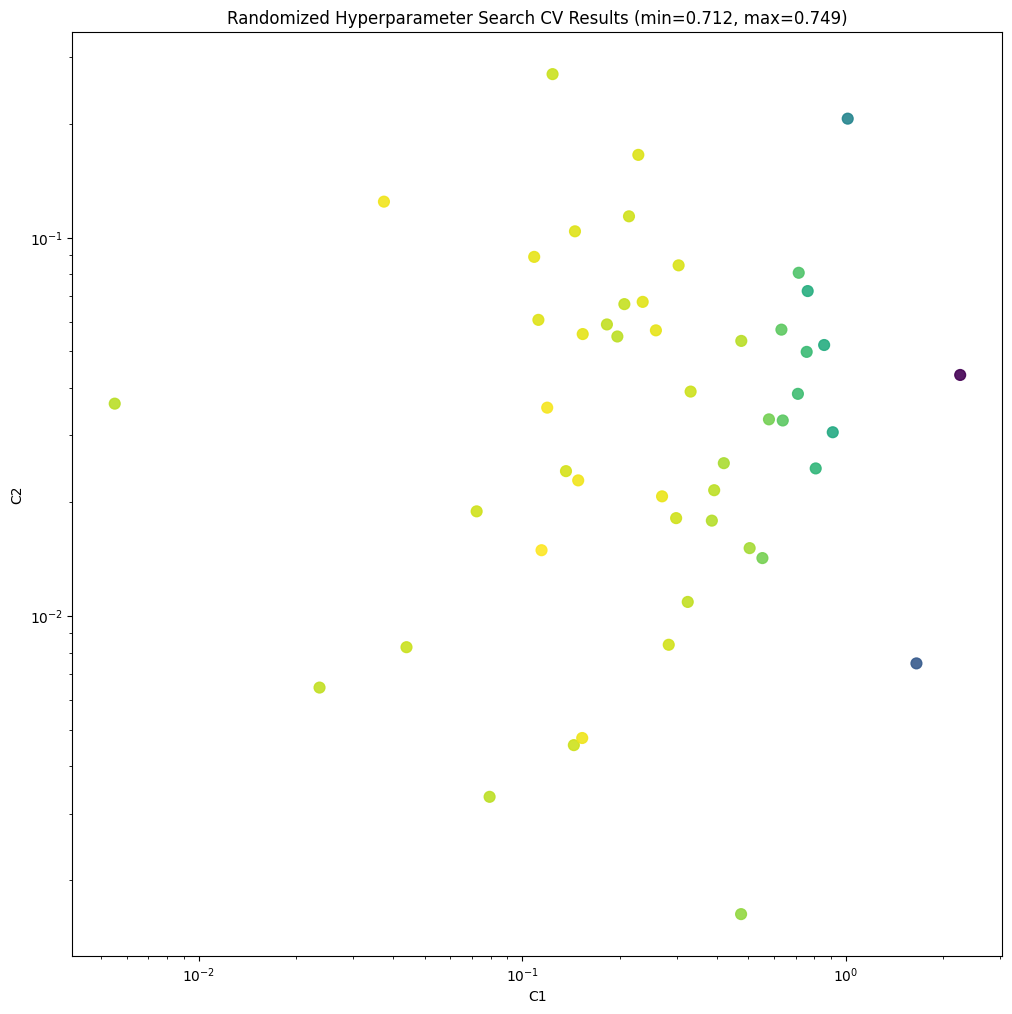

In [35]:
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c =_c, s=60, alpha=0.9)

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [25]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)  # type: ignore
print(
    metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3)
)


              precision    recall  f1-score   support

       B-LOC      0.802     0.782     0.792      1084
       I-LOC      0.678     0.634     0.655       325
      B-MISC      0.721     0.563     0.632       339
      I-MISC      0.686     0.587     0.632       557
       B-ORG      0.807     0.829     0.818      1400
       I-ORG      0.852     0.774     0.811      1104
       B-PER      0.846     0.884     0.865       735
       I-PER      0.892     0.946     0.918       634

   micro avg      0.808     0.783     0.795      6178
   macro avg      0.785     0.750     0.766      6178
weighted avg      0.805     0.783     0.793      6178



In [26]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.618126
I-ORG  -> I-ORG   7.106264
B-MISC -> I-MISC  7.081041
I-MISC -> I-MISC  6.976183
B-PER  -> I-PER   6.773041
B-LOC  -> I-LOC   5.892876
I-LOC  -> I-LOC   5.220560
I-PER  -> I-PER   5.200743
O      -> O       4.167208
O      -> B-ORG   2.859153
O      -> B-PER   2.432763
O      -> B-LOC   1.950250
O      -> B-MISC  1.792906
B-ORG  -> O       0.534211
B-MISC -> B-ORG   0.320695
I-PER  -> B-LOC   0.316532
B-ORG  -> B-LOC   0.142100
B-LOC  -> B-LOC   0.123691
B-MISC -> O       -0.004072
B-MISC -> B-LOC   -0.205722

Top unlikely transitions:
I-MISC -> I-PER   -2.930500
I-PER  -> I-LOC   -2.977057
I-LOC  -> B-MISC  -2.985614
I-ORG  -> B-LOC   -3.098760
I-MISC -> B-LOC   -3.133652
I-MISC -> I-ORG   -3.146592
I-ORG  -> I-PER   -3.200628
B-PER  -> B-MISC  -3.204621
I-PER  -> B-ORG   -3.359731
B-ORG  -> B-MISC  -3.469523
I-ORG  -> I-LOC   -3.762569
I-ORG  -> B-MISC  -3.802608
I-PER  -> B-MISC  -3.807059
B-PER  -> B-PER   -3.926250
I-MISC -> I-LOC

In [27]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr)) 

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
14.229032 B-ORG    word.lower():efe-cantabria
12.290009 B-ORG    word.lower():psoe-progresistas
10.229305 B-ORG    word.lower():petrobras
9.118974 B-ORG    word.lower():coag-extremadura
8.537345 B-LOC    +1:word.lower():finalizaron
8.475137 I-ORG    -1:word.lower():l
8.335918 I-ORG    -1:word.lower():rasd
7.671490 B-ORG    word[-2:]:-e
7.663843 B-ORG    +1:word.lower():plasencia
7.494109 B-PER    word.lower():orduña
7.461625 B-ORG    word.lower():eu-ecologista
7.347814 B-ORG    -1:word.lower():sociolaboral
7.269716 B-MISC   word.lower():cc2305001730
7.264535 B-ORG    -1:word.lower():distancia
7.060436 B-ORG    word.lower():xfera
7.049634 O        +1:word.lower():portugal
6.969253 B-LOC    -1:word.lower():celebrarán
6.942694 B-MISC   word.lower():diversia
6.791504 B-PER    word.lower():valedor
6.696440 B-LOC    -1:word.lower():cantabria
6.659876 I-ORG    -1:word.lower():ag
6.613564 O        word.lower():r.
6.613564 O        word[-3:]:R.
6.544156 B-MISC   word.lower():vacia